In [3]:
import os
import numpy as np
import pandas as pd

import folium
from folium.plugins import MarkerCluster, HeatMap
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

PATH_DATA = "..\data"
pd.set_option('display.max_columns', 30)
plotly.offline.init_notebook_mode(connected=True)

In [4]:
vkusvill_data = pd.read_csv(os.path.join(PATH_DATA, "vkusvill_data_without_target.csv"))
vkusvill_target = pd.read_csv(os.path.join(PATH_DATA, "vkusvill_target.csv"))
vkusvill = pd.merge(vkusvill_data, vkusvill_target, on="Номерточки", how="left")

vkusvill["Средний чек"] = vkusvill["Выручка р/мес"] / vkusvill["Чеки шт/мес"]

In [113]:
work_schedule = [
    ['с 9-00 до 22-00', 9, 22, 9, 22, 0], 
    ['с 8-00 до 22-00', 8, 22, 8, 22, 0],
    ['пн-чт с 7-00 - 23-45, пт-сб с 8-00 - 23-00, вс с 7-00 - 23-45', 7, 23, 7, 23, 1],
    ['Откл. с 9:00 до 22:00', 9, 22, 9, 22, 0], 
    ['с 7-00 до 22-00', 7, 22, 7, 22, 0],
    ['будни с 8-00 до 22-00; вых. с 9-00 до 22-00', 8, 22, 9, 22, 1], 
    ['с 10-00 до 22-00', 10, 22, 10, 22, 0],
    ['будни с 9-00 до 23-00, выходные с 9-00 до 22-00', 9, 23, 9, 22, 1],
    ['с 9-00 до 21-00', 9, 21, 9, 21, 0], 
    ['Будни с 8 до 23, вых с 8 до 22', 8, 23, 8, 22, 1],
    ['с 7:00 до 23:45', 7, 23, 7, 23, 0], 
    ['Откл. с 11:00 до 21:00', 11, 21, 11, 21, 0],
    ['Откл. с 8:00 до 22:00', 8, 22, 8, 22, 0], 
    ['с 8-00 до 23-45', 8, 23, 8, 23, 0], 
    ['с 8-00 до 23-00', 8, 23, 8, 23, 0],
    ['Будни с8:00 до 23:00 вых с 8:00 до 22:00', 8, 23, 8, 22, 1],
    ['будни с 8-00 до 23-00, вых. 9-00 до 23-00', 8, 23, 9, 23, 1],
    ['пн-пт с 8-00 до 23-00, сб-вс с 9-00 до 22-00', 8, 23, 9, 22, 1],
    ['вс-чт. с 10:00 до 23:00, пт-сб. с 10:00 по 24:00', 10, 23, 10, 24, 1],
    ['пн-чт с 7-00 - 23-45, пт-сб с 7-00 - 23-00, вс с 7-00 - 23-45', 7, 23, 7, 23, 1],
    ['с 8-30 до 23-00', 8, 23, 8, 23, 0], 
    ['с 7-00 до 23-45', 7, 23, 7, 23, 0],
    ['пн-чт с 7-00 - 23-45, пт-сб с 7-00 - 22-00, вс с 8-00 - 23-45', 7, 23, 8, 23, 1],
    ['с пн по чт с 7 до 23:45, пт с 7 до 23:00, сб с 8 до 22:00, вс 8 до 23:45', 7, 23, 8, 23, 1],
    ['бд 7-00 до23-00 вх 8-00 до 22-00', 7, 23, 8, 22, 1], 
    ['с 9:00 до 23:00', 9, 23, 9, 23, 0],
    ['с 7-00 до 23-00', 7, 23, 7, 23, 0]
]


work_schedule = pd.DataFrame(
    work_schedule, 
    columns=["График", "Будни начало", "Будни конец", "Выходные начало", "Выходные конец", "Разные графики"]
    )
vkusvill = pd.merge(vkusvill, work_schedule, on="График", how="left")
vkusvill['Разные графики'].replace({0: 'Одинаковые', 1: 'Разные'}, inplace=True)
vkusvill['Рабочие часы в будни'] = vkusvill['Будни конец'] - vkusvill['Будни начало']
vkusvill['Рабочие часы в выходные'] = vkusvill['Выходные конец'] - vkusvill['Выходные начало']

vkusvill['Площадь'] = pd.cut(
    vkusvill['Торговая площадь, м2'], 
    bins=[0, 120, 150, 200, float('Inf')], 
    labels=['Маленькая', 'Небольшая', 'Средняя', 'Большая']
    )

In [115]:
vkusvill.head(5)

,Наименование,Номерточки,Дата открытия,"Торговая площадь, м2",Регион,Город,Адрес,Широта,Долгота,График,Ночной магазин,Выручка р/мес,Чеки шт/мес,Средний чек,Будни начало,Будни конец,Выходные начало,Выходные конец,Разные графики,Рабочие часы в будни,Рабочие часы в выходные,Площадь
0,4548М_Нах_Белобородова6,4548,44491,52.6,Московская область,Нахабино,"ул. Белобородова, д. 6",55.850328,37.192615,с 9-00 до 22-00,Нет,39098.035556,204.773333,190.933238,9,22,9,22,Одинаковые,13,13,Маленькая
1,3297М_Некрас_мкрСтроителей42,3297,43799,78.0,Московская область,Некрасовский,"мкр. Строителей, д. 42",56.131445,37.504663,с 9-00 до 22-00,Нет,30782.080000,117.173333,262.705508,9,22,9,22,Одинаковые,13,13,Маленькая
2,1013М_МалГрузинская12,1013,42600,73.0,Москва,Москва,Малая Грузинская 12,55.763797,37.572064,с 8-00 до 22-00,Нет,28921.148889,201.533333,143.505535,8,22,8,22,Одинаковые,14,14,Маленькая
3,2530М_Мыт_Юбилейная4,2530,43661,85.5,Московская область,Мытищи,"ул. Юбилейная, д. 4",55.915306,37.720106,с 8-00 до 22-00,Нет,40527.800000,201.826667,200.804981,8,22,8,22,Одинаковые,14,14,Маленькая
4,1473М_Хим_Ленинский1,1473,43201,100.0,Московская область,Химки,"Ленинский проспект, 1к2",55.895762,37.452660,с 8-00 до 22-00,Нет,32719.211111,188.493333,173.582856,8,22,8,22,Одинаковые,14,14,Маленькая


In [116]:
vkusvill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Наименование             298 non-null    object  
 1   Номерточки               298 non-null    int64   
 2   Дата открытия            298 non-null    int64   
 3   Торговая площадь, м2     298 non-null    float64 
 4   Регион                   298 non-null    object  
 5   Город                    298 non-null    object  
 6   Адрес                    298 non-null    object  
 7   Широта                   298 non-null    float64 
 8   Долгота                  298 non-null    float64 
 9   График                   298 non-null    object  
 10  Ночной магазин           298 non-null    object  
 11  Выручка р/мес            298 non-null    float64 
 12  Чеки шт/мес              298 non-null    float64 
 13  Средний чек              298 non-null    float64 
 14  Будни нача

In [117]:
vkusvill.describe()

,Номерточки,Дата открытия,"Торговая площадь, м2",Широта,Долгота,Выручка р/мес,Чеки шт/мес,Средний чек,Будни начало,Будни конец,Выходные начало,Выходные конец,Рабочие часы в будни,Рабочие часы в выходные
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,2372.614094,43436.493289,161.918792,55.872592,37.503567,52972.447562,270.034318,199.836881,8.244966,22.234899,8.332215,22.211409,13.989933,13.879195
std,1470.987587,668.771356,73.719132,0.111359,0.206265,20419.568502,107.440551,35.304753,0.727334,0.447804,0.720341,0.440696,1.049242,1.017773
min,325.000000,41451.000000,1.000000,55.759856,35.958851,28411.980000,93.066667,125.130870,7.000000,21.000000,7.000000,21.000000,10.000000,10.000000
25%,1320.250000,43018.500000,116.375000,55.809053,37.421551,38259.795556,193.896667,175.168742,8.000000,22.000000,8.000000,22.000000,13.000000,13.000000
50%,1701.000000,43432.000000,146.000000,55.849519,37.523123,47140.657778,243.920000,197.855971,8.000000,22.000000,8.000000,22.000000,14.000000,14.000000
75%,3387.750000,43972.500000,191.300000,55.903774,37.603747,61690.487778,317.106667,218.287286,9.000000,22.000000,9.000000,22.000000,14.750000,14.000000
max,5853.000000,44855.000000,842.600000,56.734894,38.144865,160010.933333,944.440000,327.024919,11.000000,23.000000,11.000000,24.000000,16.000000,16.000000


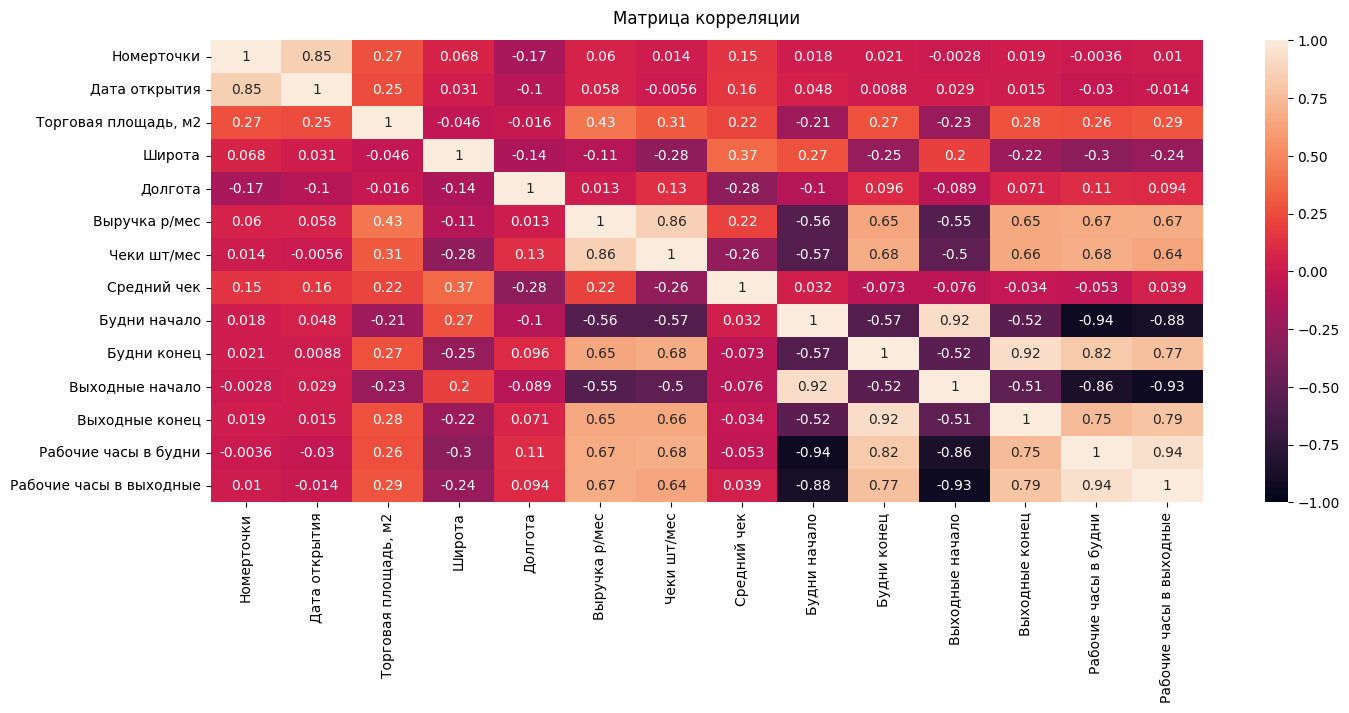

In [118]:
columns = [col for col in vkusvill.columns if vkusvill[col].dtype not in ['object', 'category']]
plt.figure(figsize=(16, 6))
plt.title('Корреляционная матрица', fontdict={'fontsize':12}, pad=12)
sns.heatmap(vkusvill[columns].corr(), vmin=-1, vmax=1, annot=True);

In [119]:
m = folium.Map(location=[vkusvill["Широта"].mean(), vkusvill["Долгота"].mean()], zoom_start=10)
marker_cluster = MarkerCluster().add_to(m)
heat_data = []
for idx, row in vkusvill.iterrows():
    location = [row["Широта"], row["Долгота"]]
    heat_data.append([row["Широта"], row["Долгота"], row["Выручка р/мес"]])
    
    folium.Marker(
        location,
        popup=f"""
        <i>Торговая площадь: </i><br><b>{row['Торговая площадь, м2']} м2</b> <br> 
        <i>График: </i><b><br>{row['График']}</b><br>
        <i>Чеки: </i><b><br>{round(row['Чеки шт/мес'], 2)}</b><br>
        <i>Выручка: </i><b><br>{round(row['Выручка р/мес'], 2)}</b><br>""", 
        ).add_to(marker_cluster)
    
HeatMap(heat_data, radius=18, gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(m)
colormap = folium.branca.colormap.LinearColormap(['blue', 'lime', 'red'], 
                                          vmin=vkusvill['Выручка р/мес'].min(), 
                                          vmax=vkusvill['Выручка р/мес'].max(),
                                          caption='Выручка р/мес')
colormap.add_to(m)
m

In [120]:
def bar_plot(
        column: str, 
        rows: int, 
        cols: int, 
        title: str, 
        width: int,
        height: int,
        xaxes: bool = True
        ):
    
    fig = make_subplots(rows=rows, cols=cols)

    data = vkusvill.groupby([column]).agg(
        {
            'Номерточки': ['count'],
            'Выручка р/мес': ['mean'],
            'Чеки шт/мес': ['mean']
            }
            ).reset_index()
    data.sort_values(column, inplace=True)
    data.columns = data.columns.droplevel(1)

    if rows <= cols:
        fig.add_bar(x=data[column], y=data["Номерточки"], row=1, col=1)
        fig.add_bar(x=data[column], y=data["Выручка р/мес"], row=1, col=2)
        fig.add_bar(x=data[column], y=data["Чеки шт/мес"], row=1, col=3)

        if xaxes:
            fig.update_xaxes(title_text=column, row=1, col=1, title_standoff=1, title_font_size=12)
            fig.update_xaxes(title_text=column, row=1, col=2, title_standoff=1, title_font_size=12)
            fig.update_xaxes(title_text=column, row=1, col=3, title_standoff=1, title_font_size=12)

        fig.update_yaxes(title_text="Количество точек", row=1, col=1, title_standoff=1, title_font_size=12)
        fig.update_yaxes(title_text="Средняя выручка", row=1, col=2, title_standoff=1, title_font_size=12)
        fig.update_yaxes(title_text="Среднее количество чеков", row=1, col=3, title_standoff=1, title_font_size=12)

    else:
        fig.add_bar(x=data[column], y=data["Номерточки"], row=1, col=1)
        fig.add_bar(x=data[column], y=data["Выручка р/мес"], row=2, col=1)
        fig.add_bar(x=data[column], y=data["Чеки шт/мес"], row=3, col=1)

        if xaxes:
            fig.update_xaxes(title_text=column, row=1, col=1, title_standoff=1, title_font_size=12)
            fig.update_xaxes(title_text=column, row=2, col=1, title_standoff=1, title_font_size=12)
            fig.update_xaxes(title_text=column, row=3, col=1, title_standoff=1, title_font_size=12)

        fig.update_yaxes(title_text="Количество точек", row=1, col=1, title_standoff=1, title_font_size=12)
        fig.update_yaxes(title_text="Средняя выручка", row=2, col=1, title_standoff=1, title_font_size=12)
        fig.update_yaxes(title_text="Среднее количество чеков", row=3, col=1, title_standoff=1, title_font_size=12)

    fig.update_layout(
        showlegend=False, 
        title={"text": title, "x": 0.5},
        autosize=False,
        width=width,
        height=height,
        )
    fig.show()

In [121]:
bar_plot(
    column='Регион', 
    rows=1, 
    cols=3, 
    title='Статистика для поля Регион', 
    width=1250,
    height=400
)

In [122]:
bar_plot(
    column='Город', 
    rows=3, 
    cols=1, 
    title='Статистика для поля Город', 
    width=1250,
    height=1000,
    xaxes=False
)

In [123]:
bar_plot(
    column='Ночной магазин', 
    rows=1, 
    cols=3, 
    title='Статистика для поля Ночной магазин', 
    width=1250,
    height=400
)

In [124]:
fig = px.histogram(vkusvill, x="Торговая площадь, м2", nbins=50)
fig.update_xaxes(title_standoff=1, title_font_size=12)
fig.update_yaxes(title_text="Количество магазинов", title_standoff=1, title_font_size=12)
fig.update_layout(
        showlegend=False, 
        autosize=False,
        width=1250,
        height=400,
        )
fig.show()

In [125]:
bar_plot(
    column='Площадь', 
    rows=1, 
    cols=3, 
    title='Статистика для нового поля Площадь', 
    width=1250,
    height=400,
    xaxes=False
)

In [126]:
bar_plot(
    column='Разные графики', 
    rows=1, 
    cols=3, 
    title='Статистика для нового поля Разные графики', 
    width=1250,
    height=400
)

In [127]:
vkusvill["Рабочие часы в будни"] = vkusvill["Рабочие часы в будни"].astype("str")
vkusvill["Рабочие часы в выходные"] = vkusvill["Рабочие часы в выходные"].astype("str")

In [128]:
bar_plot(
    column='Рабочие часы в будни', 
    rows=1, 
    cols=3, 
    title='Статистика для нового поля Рабочие часы в будни', 
    width=1250,
    height=400,
    xaxes=False
)

In [129]:
bar_plot(
    column='Рабочие часы в выходные', 
    rows=1, 
    cols=3, 
    title='Статистика для нового поля Рабочие часы в выходные', 
    width=1250,
    height=400,
    xaxes=False
)

**Выводы:**  
- Для точек из Москвы характерна более высокая выручка по сравнению с точками из Московской области;
- Также размер выручки зависит и от самого города, а не только от региона;
- Из графика работы магазина была получена информация о времени работы в будние и в выходные дни, для магазинов с 15-16 часовым рабочим днем характерен наибольший объем выручки;
- Для ночных магазинов характерен более высокий объем выручки, что сходится с предыдущим утверждением;
- Установлена зависимость между торговой площадью и таргетом, с ростом площади точки увеличивается и объем выручки;
- Необходимо дополнить текущие данные объектами, находящимися вблизи магазинов (OpenStreetMap).